In [1]:
import sys
import os
import numpy as np

# Navigate to the parent directory of the project structure
project_dir = os.path.abspath(os.path.join(os.getcwd(), '../'))
src_dir = os.path.join(project_dir, 'src')
data_dir = os.path.join(project_dir, 'data')
fig_dir = os.path.join(project_dir, 'fig')
logs_dir = os.path.join(project_dir, 'logs')
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)

# Add the src directory to sys.path
sys.path.append(src_dir)
from plot import plot_score_distribution
from dataset import generate_poisoned_canaries_and_mask

In [ ]:
# ==========================================
# Hyperparameters (Settings from the paper "Unlocking High-Accuracy Differentially Private Image Classification through Scale")
# ==========================================
LOGICAL_BATCH_SIZE = 4096     # Target batch size (Paper)
MAX_PHYSICAL_BATCH_SIZE = 128  # GPU limit (128 * 16 = 512 effective images)
AUG_MULTIPLICITY = 16         # K=16 augmentations
MAX_GRAD_NORM = 1.0
EPSILON = 8.0
DELTA = 1e-5
EPOCHS = 140                   # Increase to 100+ for best results
LR = 4.0                      # High LR for large batch
MOMENTUM = 0.0                # No momentum
NOISE_MULTIPLIER = 3.0        # Sigma ~ 3.0 is optimal for BS=4096
CKPT_INTERVAL = 20            # Save checkpoint every 10 epochs


# ==========================================
# Experiment Parameters
# ==========================================
CANARY_COUNT = 5000           # Number of canaries
PKEEP = 0.5                   # Probability of including each canary in the training set
DATABSEED = 53841938803364779163249839521218793645  # if seed is set to None then seed is random
     

In [3]:
exp_dir = os.path.join(data_dir, f"mislabeled-canaries-{DATABSEED}-{CANARY_COUNT}-{PKEEP}-cifar10")
assert os.path.exists(exp_dir), f"Experiment directory {exp_dir} does not exist. You need to train an auditable DP-SGD model first. See train_auditable_DP_model_blackbox.ipynb as an example."

scores_dir = os.path.join(exp_dir, "scores")
assert os.path.exists(scores_dir), f"Scores directory {scores_dir} does not exist. Please run infer_auditable_DP_model.ipynb first."

# Load canary database and mask to get inclusion_mask
print("Loading canary database and mask...")
poisoned_canaries, inclusion_mask = generate_poisoned_canaries_and_mask(
    data_dir=data_dir,
    canary_count=CANARY_COUNT,
    seed=DATABSEED,
    pkeep=PKEEP
)

print(f"Loaded {len(poisoned_canaries)} total canaries")
print(f"  - In-canaries (included in training): {np.sum(inclusion_mask)}")
print(f"  - Out-canaries (excluded from training): {np.sum(~inclusion_mask)}")

Loading canary database and mask...


/tmp/python-venv/dpsgd-auditbench_venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Loaded 5000 total canaries
  - In-canaries (included in training): 2488
  - Out-canaries (excluded from training): 2512


Loading score files from scores directory...
Found 1 score files: ['0000000020.npy']

Processing score file: 0000000020.npy (epoch: 20)
  In-canaries:  mean=-1.4214, std=1.7950, min=-9.1865, max=2.3004
  Out-canaries: mean=-1.5413, std=1.8373, min=-10.0343, max=2.3285


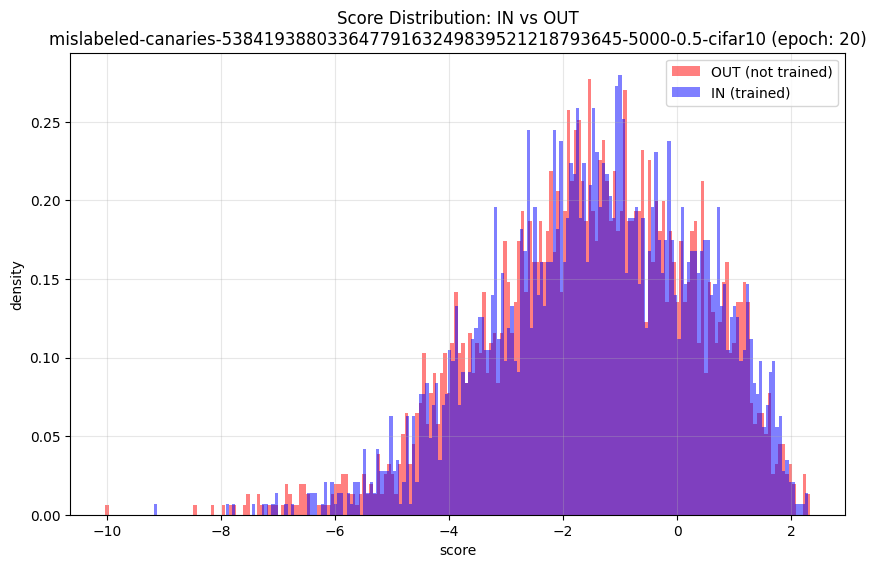

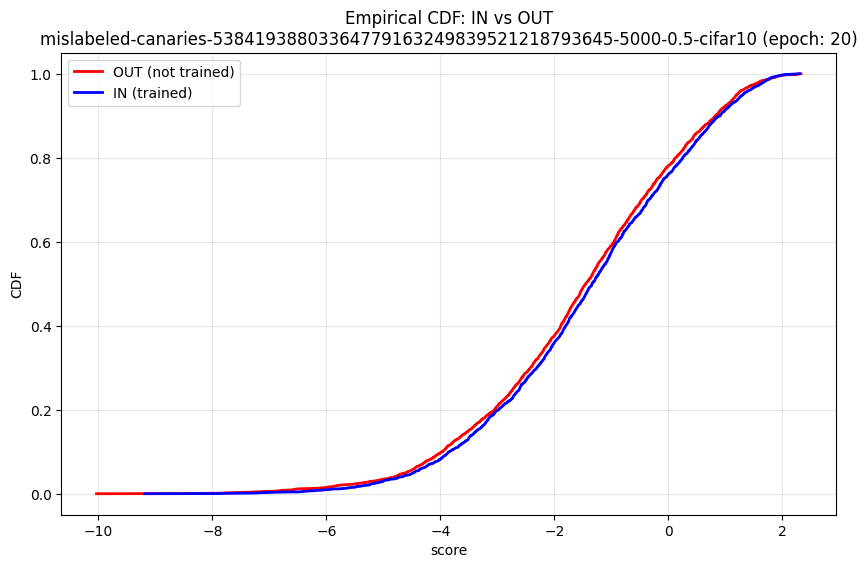


✅ Finished plotting all score distributions!


In [4]:
# Load all score files and plot distributions
print("Loading score files from scores directory...")
score_files = [f for f in os.listdir(scores_dir) if f.endswith('.npy')]
score_files.sort()  # Sort to process in order

if not score_files:
    print("No score files found!")
else:
    print(f"Found {len(score_files)} score files: {score_files}")
    exp_dir_name = os.path.basename(exp_dir)
    
    # Process each score file
    for score_file in score_files:
        score_path = os.path.join(scores_dir, score_file)
        ckpt_name = score_file.replace('.npy', '')  # e.g., "0000000020"
        
        # Extract epoch number from checkpoint name
        try:
            epoch = int(ckpt_name)
        except ValueError:
            epoch = ckpt_name  # Use the name as-is if not a number
        
        print(f"\nProcessing score file: {score_file} (epoch: {epoch})")
        
        # Load scores for all canaries (in original order)
        all_scores = np.load(score_path)
        
        # Split into in-canaries and out-canaries using the mask
        in_scores = all_scores[inclusion_mask]
        out_scores = all_scores[~inclusion_mask]
        
        print(f"  In-canaries:  mean={in_scores.mean():.4f}, std={in_scores.std():.4f}, min={in_scores.min():.4f}, max={in_scores.max():.4f}")
        print(f"  Out-canaries: mean={out_scores.mean():.4f}, std={out_scores.std():.4f}, min={out_scores.min():.4f}, max={out_scores.max():.4f}")
        
        # Plot score distribution
        plot_score_distribution(in_scores, out_scores, exp_dir_name, epoch)
    
    print("\n✅ Finished plotting all score distributions!")